_Neural Data Analysis_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Sarah Strauss, Ziwei Huang

Summer term 2021

Student name: *Harry Antony (MSc NIP | 5610172), Nishad Singhi (MSc NIP | 5619175)*

# Coding Lab 4

Two-photon imaging is widely used to study computations in populations of neurons. In this exercise sheet we will study properties of different indicators and work on methods to infer spikes from calcium traces. All data is provided at a sampling rate of 100 Hz. For analysis, please resample it to 25 Hz using `np.decimate`.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import loadmat
import oopsi

sns.set_style('whitegrid')
%matplotlib inline

## Load data

We are working with two different calcium indicators (37 and 11 cells), for each there is also a spike recording. There can be multiple spikes within one time bin so the spikes datasets are not binary.

In [3]:
# ogb dataset from Theis et al. 2016 Neuron
ogb_calcium = pd.read_csv('../data/nda_ex_4_ogb_calcium.csv', header=0)  
ogb_spikes = pd.read_csv('../data/nda_ex_4_ogb_spikes.csv', header=0)  

# gcamp dataset from Chen et al. 2013 Nature
gcamp_calcium = pd.read_csv('../data/nda_ex_4_gcamp2_calcium.csv', header=0)  
gcamp_spikes = pd.read_csv('../data/nda_ex_4_gcamp2_spikes.csv', header=0)  

## Task 1: Visualization of calcium and spike recordings

We start again by plotting the raw data - calcium and spike traces in this case. One dataset has been recorded using the synthetic calcium indicator OGB-1 at population imaging zoom (~100 cells in a field of view) and the other one using the genetically encoded indicator GCamp6f zooming in on individual cells. Plot the traces of an example cell from each dataset to show how spikes and calcium signals are related. A good example cell for the OGB-dataset is cell 5. Zoom in on a small segment of tens of seconds and offset the traces such that a valid comparison is possible.

*Grading: 2 pts*

Text(0.5, 1.0, 'GCAMP')

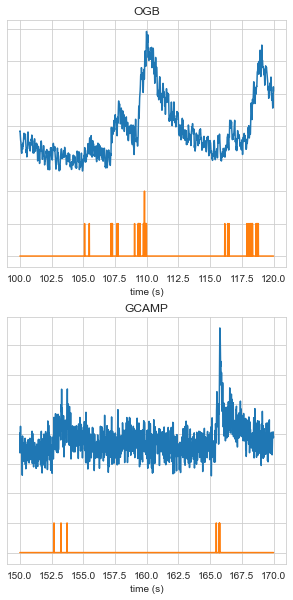

In [4]:
plt.figure(figsize=(5, 10))

f = 100

plotting_time_start = 100
plotting_time_end = 120
time = np.linspace(plotting_time_start, plotting_time_end, (plotting_time_end - plotting_time_start)*f)

ax1 = plt.subplot2grid((2, 1), (0, 0))
ax1.plot(time, ogb_calcium.iloc[plotting_time_start*f:plotting_time_end*f, 4])
ax1.plot(time, ogb_spikes.iloc[plotting_time_start*f:plotting_time_end*f, 4]-3)
ax1.set_yticklabels([])
ax1.set_xlabel("time (s)")
ax1.set_title("OGB")

plotting_time_start = 150
plotting_time_end = 170
time = np.linspace(plotting_time_start, plotting_time_end, (plotting_time_end - plotting_time_start)*f)

ax2 = plt.subplot2grid((2, 1), (1, 0))
ax2.plot(time, gcamp_calcium.iloc[plotting_time_start*f:plotting_time_end*f, 4])
ax2.plot(time, gcamp_spikes.iloc[plotting_time_start*f:plotting_time_end*f, 4]-3)
ax2.set_yticklabels([])
ax2.set_xlabel("time (s)")
ax2.set_title("GCAMP")

## Task 2: Simple deconvolution

It is clear from the above plots that the calcium events happen in relationship to the spikes. As a first simple algorithm implement a deconvolution approach like presented in the lecture in the function `deconv_ca`. Assume an exponential kernel where the decay constant depends on the indicator ($\tau_{OGB}= 0.5 s$, $\tau_{GCaMP}= 0.1 s$). As we know that there can be no negative rates, apply a heavyside function to the output. Plot the kernel as well as an example cell with true and deconvolved spike rates. Scale the signals such as to facilitate comparisons.

*Grading: 3 pts*


In [5]:
def deconv_ca(ca, dt, tau):
# Compute the deconvolved calcium signal 
#   sp_hat = deconv_ca(ca, sp, tau) computes the deconvolved calcium signal
#   using the indicator dependent exponential calicum kernel.
#
#   ca:    1 by T
#   dt:    time resolution of the data
#   tau:   1 by 1
#
#   return: sp_hat: 1 by T

   # fill your code here
    T = np.size(ca)
    kernel_len = 10
    t = np.linspace(0, kernel_len, int(kernel_len/dt))
    kernel = np.exp(-t/tau)
    
    sp_hat_, remainder = signal.deconvolve(ca, kernel)
    sp_hat_[sp_hat_ < 0] = 0
    sp_hat = np.zeros(T)
    sp_hat[:len(sp_hat_)] = sp_hat_
    
    return sp_hat

#### Apply the function to the example OGB cell

In [6]:
idx = 4
ca = signal.decimate(ogb_calcium.iloc[:,idx], 4)
sp = signal.decimate(ogb_spikes.iloc[:,idx], 4)
sp[sp<0] = 0 # remove decimation artefacts

tau = .5 # in sec
dt = 1/25 # in sec

sp_hat = deconv_ca(ca, dt, tau)

Text(0.5, 1.0, 'Exponential kernel ($\\tau$ = 0.5)')

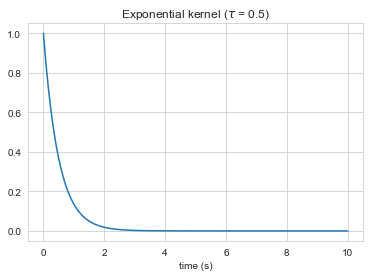

In [7]:
T = np.size(ca)
kernel_len = 10
t = np.linspace(0, kernel_len, int(kernel_len/dt))
kernel = np.exp(-t/tau)

plt.plot(t, kernel)
plt.xlabel("time (s)")
plt.title(r"Exponential kernel ($\tau$ = " + f"{tau})")

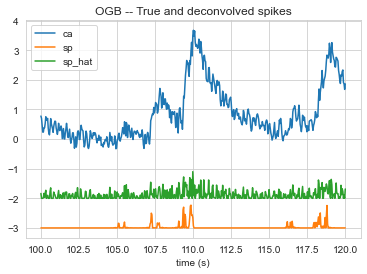

In [8]:
# fill in plot here
f = int(1/dt)
plotting_time_start = 100
plotting_time_end = 120
time = np.linspace(plotting_time_start, plotting_time_end, (plotting_time_end - plotting_time_start)*f)

plt.plot(time, ca[plotting_time_start*f:plotting_time_end*f], label='ca')
plt.plot(time, sp[plotting_time_start*f:plotting_time_end*f]-3, label='sp')
plt.plot(time, sp_hat[plotting_time_start*f:plotting_time_end*f]-2, label='sp_hat')
plt.xlabel("time (s)")
plt.title("OGB -- True and deconvolved spikes")
plt.legend()

### Apply the function to the example GCamP cell

In [9]:
idx = 5
ca = signal.decimate(gcamp_calcium.iloc[:,idx], 4)
sp = signal.decimate(gcamp_spikes.iloc[:,idx], 4)
sp[sp<0] = 0 # remove decimation artefacts


tau = .1

sp_hat = deconv_ca(ca, dt, tau)

Text(0.5, 1.0, 'Exponential kernel ($\\tau$ = 0.1)')

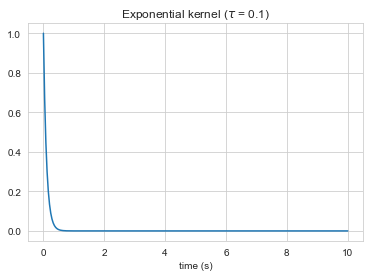

In [10]:
T = np.size(ca)
kernel_len = 10
t = np.linspace(0, kernel_len, int(kernel_len/dt))
kernel = np.exp(-t/tau)

plt.plot(t, kernel)
plt.xlabel("time (s)")
plt.title(r"Exponential kernel ($\tau$ = " + f"{tau})")

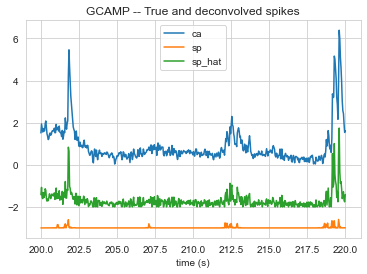

In [11]:
# fill in plot here
f = int(1/dt)
plotting_time_start = 200
plotting_time_end = 220
time = np.linspace(plotting_time_start, plotting_time_end, (plotting_time_end - plotting_time_start)*f)

plt.plot(time, ca[plotting_time_start*f:plotting_time_end*f], label='ca')
plt.plot(time, sp[plotting_time_start*f:plotting_time_end*f]-3, label='sp')
plt.plot(time, sp_hat[plotting_time_start*f:plotting_time_end*f]-2, label='sp_hat')
plt.xlabel("time (s)")
plt.title("GCAMP -- True and deconvolved spikes")
plt.legend()

## Task 3: Run more complex algorithm

As reviewed in the lecture, a number of more complex algorithms for inferring spikes from calcium traces have been developed. Run an implemented algorithm on the data and plot the result. There is a choice of algorithms available, for example:

* Vogelstein: [oopsi](https://github.com/liubenyuan/py-oopsi)
* Theis: [c2s](https://github.com/lucastheis/c2s)
* Friedrich: [OASIS](https://github.com/j-friedrich/OASIS)

Note: If you have troubles with installing one of them maybe try another.

*Grading: 2 pts*



In [14]:
idx = 4
ca = signal.decimate(ogb_calcium.iloc[:,idx], 4)
sp = signal.decimate(ogb_spikes.iloc[:,idx], 4)
sp[sp<0] = 0 # remove decimation artefacts


# fill in algorithm here
n_best, _ = oopsi.fast(ca, dt, iter_max=1, update=True)

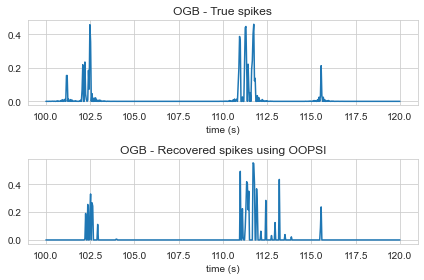

In [37]:
# fill in plot here
fig, ax = plt.subplots(nrows=2, ncols=1)

plot_time_start = 100
plot_time_end = 120
time = np.linspace(plot_time_start, plot_time_end, (plot_time_end - plot_time_start)*f)

ax1 = ax[0]
ax1.plot(time,sp[plotting_time_start*f:plotting_time_end*f])
ax1.set_xlabel("time (s)")
ax1.set_title("OGB - True spikes")

ax2 = ax[1]
ax2.plot(time,n_best[plotting_time_start*f:plotting_time_end*f])
ax2.set_xlabel("time (s)")
ax2.set_title("OGB - Recovered spikes using OOPSI")

fig.tight_layout()

In [33]:
idx = 4
ca = signal.decimate(ogb_calcium.iloc[:,idx], 4)
sp = signal.decimate(ogb_spikes.iloc[:,idx], 4)
sp[sp<0] = 0 # remove decimation artefacts


# fill in algorithm here
n_best, _ = oopsi.fast(ca, dt, iter_max=1, update=True)

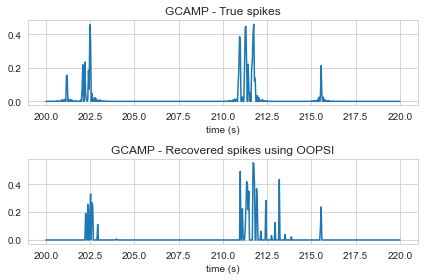

In [39]:
# fill in plot here
fig, ax = plt.subplots(nrows=2, ncols=1)

plot_time_start = 200
plot_time_end = 220
time = np.linspace(plot_time_start, plot_time_end, (plot_time_end - plot_time_start)*f)

ax1 = ax[0]
ax1.plot(time,sp[plotting_time_start*f:plotting_time_end*f])
ax1.set_xlabel("time (s)")
ax1.set_title("GCAMP - True spikes")

ax2 = ax[1]
ax2.plot(time,n_best[plotting_time_start*f:plotting_time_end*f])
ax2.set_xlabel("time (s)")
ax2.set_title("GCAMP - Recovered spikes using OOPSI")

fig.tight_layout()

## Task 4: Evaluation of algorithms

To formally evaluate the algorithms on the two datasets run the deconvolution algorithm and the more complex one on all cells and compute the correlation coefficient between true and inferred spike trains. `DataFrames` from the `pandas` package are a useful tool for aggregating data and later plotting it. Create a dataframe with columns

* algorithm
* correlation
* indicator

and enter each cell. Plot the results using `stripplot` and/or `boxplot` in the `seaborn` package. 
Make sure one can compare algorithms and indicators meaningfully.

*Grading: 3 pts*


Evaluate on OGB data

In [76]:
num_cells = ogb_calcium.shape[1]
dt = 1/25
tau = 0.5

df_OGB = pd.DataFrame(columns=['cell', 'algorithm', 'correlation', 'indicator'])

row = 0
for cell in range(num_cells):
    ca = np.nan_to_num(ogb_calcium.iloc[:,cell])
    sp = np.nan_to_num(ogb_spikes.iloc[:,cell])

    sp_oopsi, _ = oopsi.fast(ca, dt, iter_max=1, update=True)
    correlation_oopsi = np.corrcoef(sp_oopsi, sp)[1][0]
    df_OGB.loc[row] = [cell, 'OOPSI', correlation_oopsi, 'OGB']
    row += 1
    
    sp_deconv = deconv_ca(ca, dt, tau)
    correlation_deconv = np.corrcoef(sp_deconv, sp)[1][0]
    df_OGB.loc[row] = [cell, 'deconv', correlation_deconv, 'OGB']
    row += 1

Evaluate on GCamp data

In [84]:
num_cells = gcamp_calcium.shape[1]
dt = 1/25
tau = 0.5

df_GCAMP = pd.DataFrame(columns=['cell', 'algorithm', 'correlation', 'indicator'])

row = 0
for cell in range(num_cells):
    ca = np.nan_to_num(gcamp_calcium.iloc[:,cell])
    sp = np.nan_to_num(gcamp_spikes.iloc[:,cell])

    sp_oopsi, _ = oopsi.fast(ca, dt, iter_max=1, update=True)
    correlation_oopsi = np.corrcoef(sp_oopsi, sp)[1][0]
    df_GCAMP.loc[row] = [cell, 'OOPSI', correlation_oopsi, 'GCAMP']
    row += 1
    
    sp_deconv = deconv_ca(ca, dt, tau)
    correlation_deconv = np.corrcoef(sp_deconv, sp)[1][0]
    df_GCAMP.loc[row] = [cell, 'deconv', correlation_deconv, 'GCAMP']
    row += 1


Combine both dataframes and plot

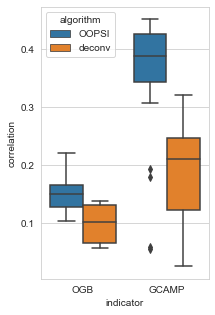

In [86]:
plt.figure(figsize=(3, 5))

df_combined = pd.concat([df_OGB, df_GCAMP])

ax = sns.boxplot(x="indicator", y="correlation", hue="algorithm",
                 data=df_combined)

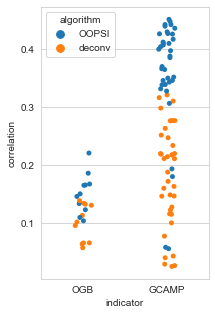

In [87]:
plt.figure(figsize=(3, 5))

df_combined = pd.concat([df_OGB, df_GCAMP])

ax = sns.stripplot(x="indicator", y="correlation", hue="algorithm",
                 data=df_combined)

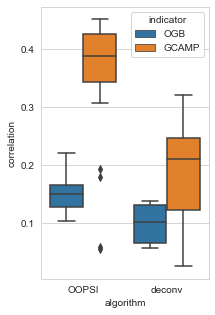

In [85]:
plt.figure(figsize=(3, 5))

df_combined = pd.concat([df_OGB, df_GCAMP])

ax = sns.boxplot(x="algorithm", y="correlation", hue="indicator",
                 data=df_combined)

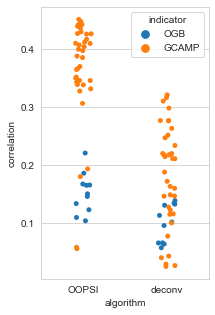

In [89]:
plt.figure(figsize=(3, 5))

df_combined = pd.concat([df_OGB, df_GCAMP])

ax = sns.stripplot(x="algorithm", y="correlation", hue="indicator",
                 data=df_combined)